# Setup stuff

In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import csv

from IPython.display import display, HTML

from treasurer.data import DataTools
from treasurer.summary import SummaryTools

idr_aud_conversion_factor = 10_000
idr_aud_col_equiv = [
    ('IDR - Expenses', 'AUD - Expenses'),
    ('IDR - Income', 'AUD - Income'),
    ('IDR - Account Balance', 'AUD - Balance'),
]

In [30]:
data_dir = '../../data/'
file_bang, file_indo = ('sies-bangalow-20190912-01', 'sies-indonesia-20190912-01')

bang = DataTools.load_data_file(data_dir, file_bang)
bang['Account'] = 'Bangalow'

indo = DataTools.load_data_file(data_dir, file_indo)
indo['Account'] = 'Indonesia'

indo['Non-SIES'] = (~indo['Via The SIES Account'])
indo = indo.drop('Via The SIES Account', axis=1)

indo['Internal'] = indo['Internal Transaction']
indo = indo.drop('Internal Transaction', axis=1)

for a, b in idr_aud_col_equiv:
    indo[b] = indo[a] / idr_aud_conversion_factor
    indo = indo.drop(a, axis=1)
    
full = bang.append(indo, sort=False)
# full = full.sort_values(by='date')

full = full.rename(columns={
    'AUD - Expenses': 'Expenses',
    'AUD - Income': 'Income',
    'AUD - Balance': 'Balance',
})

# print(full.dtypes)
# print(full.shape)
# print(full[(full['Expenses'].isnull() & full['Income'].isnull())])

,Expenses
Elephant Conservation Projects,"-7,000"
Fees,-280
Habitat Regeneration Projects,"-80,000"
Volunteer Program Costs,"-2,416"
White Wind Duck Conservation Projects,"-5,000"
Total,"-94,696"


,Income
Eco-Tours Income,"2,500"
Habitat Regeneration Campaign,"20,581"
Public Donations,"29,670"
Volunteer Program Income,"30,840"
White Wind Duck Conservation Campaign,"11,000"
Total,"94,592"


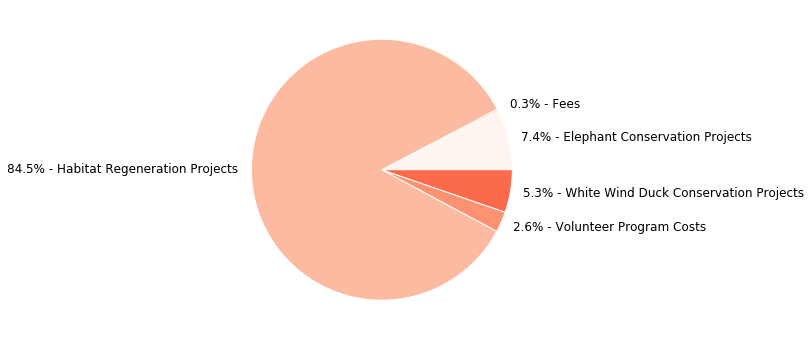

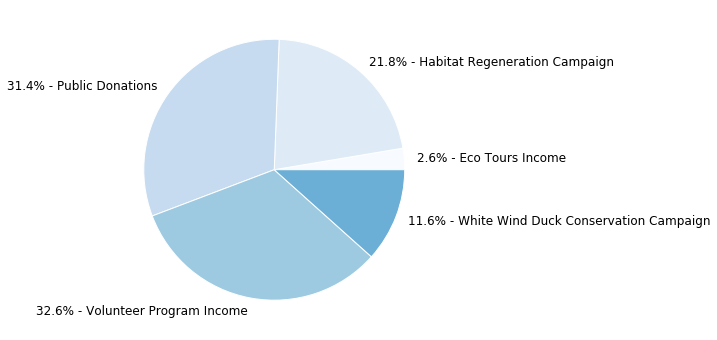

In [34]:
project_groups = {
    'Expenses': {
        'Administration-Expense': 'Fees',
        'Administrative-Expense': 'Fees',
        'Bank-Transfer-Expense': 'Fees',
        'ALeRT-Tour-Donation': 'Volunteer Program Costs',
        'SCU-Tour-Payments': 'Volunteer Program Costs',
        'General-Tour': 'Volunteer Program Costs',
        'Friends-of-the-National-Park-Foundation': 'Orangutan Conservation Projects',
        'Gunung-Palung-National-Park': 'Orangutan Conservation Projects',
        'Orangutan-Green-Projects': 'Orangutan Conservation Projects',
        'Yayasan-Orangutan-Sumatra-Lestari': 'Orangutan Conservation Projects',
        'Susukan-Baru-Project': 'Habitat Regeneration Projects',
        'Way-Kambas-National-Park-Firefighting-Project': 'Habitat Regeneration Projects',
        'Way-Kambas-National-Park-Reforestation-Project': 'Habitat Regeneration Projects',
        'Tour-Expense-Cash-Withdrawal': 'Eco-Tours Expenses',
        'International-Park-Tours': 'Eco-Tours Expenses',
        'Way-Kambas-National-Park-General': 'Other Projects',
        'Recurring-Sponsorships': 'Other Projects',
        'Way-Kambas-National-Park-Elephant-Project': 'Elephant Conservation Projects',
        'Way-Kambas-National-Park-WWD-Project': 'White Wind Duck Conservation Projects',
        'Payment for Tshirts': 'Volunteer Program Costs',
        'Initial-Balance': 'ERRORS',
        'Transfer-Error': 'ERRORS',
        'General-Donation': 'ERRORS',
        'General-Donation-via-PayPal': 'ERRORS',
        'SCU-Fundraising': 'ERRORS',
        'Volunteer-Tour-Donation': 'ERRORS',
        'Transfer-to-the-Bali-Account': 'ERRORS',
        np.nan: 'ERRORS',
    },
    'Income': {
        'Initial-Balance': 'Balance',
        'Balance': 'Balance',
        'Donation-from-Taronga': 'Grants',
        'Susukan-Baru-Project': 'Grants',
        'General-Donation-via-Planet-Funder': 'Volunteer Program Income',
        'SCU-Fundraising': 'Volunteer Program Income',
        'SCU-Tour-Payments': 'Volunteer Program Income',
        'Orangutan-Green-Projects': 'Orangutan Conservation Campaign',
        'Way-Kambas-National-Park-Elephant-Project': 'Elephant Conservation Campaign',
        'Way-Kambas-National-Park-WWD-Project': 'White Wind Duck Conservation Campaign',
        'General-Tour': 'Eco-Tours Income',
        'International-Park-Tours': 'Eco-Tours Income',
        'Steppes-Travel-Tour': 'Eco-Tours Income',
        'Volunteer-Tour-Donation': 'Eco-Tours Income',
        'Donation-for-Tigers': 'Public Donations',
        'General-Donation': 'Public Donations',
        'General-Donation-via-PayPal': 'Public Donations',
        'Recurring-Sponsorships': 'Public Donations',
        'Way-Kambas-National-Park-Reforestation-Project': 'Habitat Regeneration Campaign',
        'Way-Kambas-National-Park-General': 'Other Projects',
        'Yayasan-Orangutan-Sumatra-Lestari': 'Orangutan Conservation Projects',
        'Administration-Expense': 'ERRORS',
        'Bank-Transfer-Expense': 'ERRORS',
        'Tour-Expense-Cash-Withdrawal': 'ERRORS',
        'Transfer-to-the-Bali-Account': 'ERRORS',
        np.nan: 'ERRORS',
    },
}

sort_order = {
    'Expenses': (
        'Eco-Tours Expenses',
        'Elephant Conservation Projects',
        'Fees',
        'Habitat Regeneration Projects',
        'Volunteer Program Costs',
        'White Wind Duck Conservation Projects',
    ),
    'Income': (
        'Eco-Tours Income',
        'Habitat Regeneration Campaign',
        'Public Donations',
        'Volunteer Program Income',
        'White Wind Duck Conservation Campaign',
    )
}

SummaryTools.test_for_missing_groups(full, project_groups)
summaries = SummaryTools.pretty_summary(full, project_groups, 2018)
for i, s in summaries:
    # s = s.reindex(sort_order[i])
    SummaryTools.pie_chart(s.to_frame(), i)
    s['Total'] = s.sum()
    display(HTML(s.to_frame().to_html(formatters={i: lambda x: '{:,.0f}'.format(x)})))
    # print(s.reindex(sort_order[i]))

In [46]:
account = 'Bangalow'
print('Summary by Financial Year: {} account only'.format(account))
s = SummaryTools.fy_summary(full[full['Account'] == account])
s = s.drop('Balance', axis=1)
s = s.drop('Internal', axis=1)
s = s.drop('Non-SIES', axis=1)
display(HTML(s.to_html(formatters={
    'Expenses': lambda x: '{:,.0f}'.format(x),
    'Income': lambda x: '{:,.0f}'.format(x),
})))

Summary by Financial Year: Bangalow account only


,Expenses,Income
date,,
2012,-11,"9,439"
2013,"-68,962","79,716"
2014,"-58,940","53,652"
2015,"-38,620","44,250"
2016,"-98,800","104,860"
2017,"-75,010","68,403"
2018,"-94,696","94,592"


In [47]:
account, year = 'Bangalow', 2018
print('Summary by Project Code: financial year starting {} and {} account only'.format(year, account))
s = SummaryTools.project_summary(full[(
    (full['Account'] == account) &
    SummaryTools.fy_filter(full, year)
)])
s = s.drop('Balance', axis=1)
s = s.drop('Internal', axis=1)
s = s.drop('Non-SIES', axis=1)
display(HTML(s.to_html(formatters={
    'Expenses': lambda x: '{:,.0f}'.format(x),
    'Income': lambda x: '{:,.0f}'.format(x),
})))

Summary by Project Code: financial year starting 2018 and Bangalow account only


,Expenses,Income
Project Codes,,
Administrative-Expense,-250,0
Bank-Transfer-Expense,-30,0
General-Donation,0,"23,010"
General-Donation-via-PayPal,0,"6,660"
International-Park-Tours,0,"2,500"
Payment for Tshirts,"-1,208",0
SCU-Fundraising,0,"30,840"
SCU-Tour-Payments,"-1,208",0
Way-Kambas-National-Park-Elephant-Project,"-7,000",0


In [45]:
year = 2018
print('Summary by Project Code: financial year starting {}, both accounts'.format(year))
s = full[SummaryTools.fy_filter(full, year)].groupby('Project Codes').sum()
s = s.drop('Balance', axis=1)
display(HTML(s.to_html(formatters={
    'Expenses': lambda x: '{:,.0f}'.format(x),
    'Income': lambda x: '{:,.0f}'.format(x),
})))

Summary by Project Code: financial year starting 2018, both accounts


,Expenses,Income,Non-SIES,Internal
Project Codes,,,,
Administrative-Expense,-250,0,0.0,0.0
Bank-Transfer-Expense,-30,0,0.0,0.0
General-Donation,0,"23,010",0.0,0.0
General-Donation-via-PayPal,0,"6,660",0.0,0.0
International-Park-Tours,0,"2,500",0.0,0.0
Payment for Tshirts,"-1,208",0,0.0,0.0
SCU-Fundraising,0,"30,840",0.0,0.0
SCU-Tour-Payments,"-1,208",0,3.0,0.0
Way-Kambas-National-Park-Elephant-Project,"-7,000",0,0.0,0.0
